## Étape 1 : Préparation de l'Environnement

### 1.1. Importer les Bibliothèques Nécessaires

In [4]:
import tensorflow as tf
import numpy as np
import librosa
import librosa.display
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

## Étape 2 : Définir les Constantes et les Classes

### 2.1. Constantes

In [5]:
# ✅ Constants
SAMPLE_RATE = 22050  # UrbanSound8K uses 22050 Hz
N_MELS = 128  # Number of Mel bands
MAX_TIME_STEPS = 87  # Fixed length for spectrograms (approx 4 seconds)
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
EPOCHS = 50

### 2.2. Classes

Les classes pour UrbanSound8K sont les suivantes :

In [6]:
CLASSES = [
    "air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling",
    "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"
]
NUM_CLASSES = len(CLASSES)

## Étape 3 : Charger les Métadonnées

### 3.1. Charger les Métadonnées

In [7]:
# ✅ Load Metadata
metadata_path = "/kaggle/input/urban-sound-8k/UrbanSound8K.csv"
metadata = pd.read_csv(metadata_path)

## Étape 4 : Convertir les Fichiers Audio en Spectrogrammes

### 4.1. Fonction pour Convertir les Fichiers Audio en Spectrogrammes

In [8]:
# ✅ Convert WAV to Log-Mel Spectrogram
def get_mel_spectrogram(file_path):
    try:
        audio, _ = librosa.load(file_path, sr=SAMPLE_RATE)
        
        # Adjust n_fft based on the length of the audio signal
        n_fft = min(2048, len(audio))  # Use 2048 or the length of the signal, whichever is smaller
        
        mel_spectrogram = librosa.feature.melspectrogram(
            y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=n_fft, hop_length=512
        )
        log_mel_spectrogram = np.log(mel_spectrogram + 1e-9)
        return log_mel_spectrogram.T  # Transpose to (time_steps, n_mels)
    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None

### 4.2. Fonction pour Tronquer ou Remplir les Spectrogrammes

In [9]:
# ✅ Pad or Truncate Spectrograms
def pad_or_truncate(spectrogram):
    if spectrogram.shape[0] > MAX_TIME_STEPS:
        return spectrogram[:MAX_TIME_STEPS, :]  # Truncate
    else:
        return np.pad(spectrogram, ((0, MAX_TIME_STEPS - spectrogram.shape[0]), (0, 0)), mode="constant")

## Étape 5 : Charger les Données

### 5.1. Fonction pour Charger les Données

In [10]:
# ✅ Load Dataset
def load_dataset(metadata, data_path):
    spectrograms, labels = [], []
    
    for idx, row in metadata.iterrows():
        file_path = os.path.join(data_path, f"fold{row['fold']}", row["slice_file_name"])
        mel_spec = get_mel_spectrogram(file_path)
        if mel_spec is not None:
            mel_spec = pad_or_truncate(mel_spec)
            spectrograms.append(mel_spec)
            labels.append(row["classID"])  # Use classID as label
    
    return np.array(spectrograms), np.array(labels)

#### 5.2. Charger les Données

In [11]:
# ✅ Load Data
data_path = "/kaggle/input/urban-sound-8k/UrbanSound8K/UrbanSound8K/audio"
spectrograms, labels = load_dataset(metadata, data_path)

# ✅ Split into Train and Validation Sets
train_spectrograms, val_spectrograms, train_labels, val_labels = train_test_split(spectrograms, labels, test_size=0.2, random_state=42)

# ✅ Normalize Data
mean = np.mean(train_spectrograms)
std = np.std(train_spectrograms)

train_spectrograms = (train_spectrograms - mean) / std
val_spectrograms = (val_spectrograms - mean) / std

print("✅ Dataset loaded successfully!")
print(f"Train Shape: {train_spectrograms.shape}, Val Shape: {val_spectrograms.shape}")

✅ Dataset loaded successfully!
Train Shape: (6985, 87, 128), Val Shape: (1747, 87, 128)


## Étape 6 : Définir et Compiler le Modèle

### 6.1. Définir TimeScaleNet

In [12]:
# ✅ Define TimeScaleNet Model
def BiquadNet(input_tensor):
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0))(input_tensor)  # 🔥 Increased Dropout
    x = layers.LayerNormalization()(x)
    return x

def FrameNet(input_tensor):
    # Atrous Convolutions
    x = layers.Conv1D(128, kernel_size=3, padding="same", dilation_rate=1, activation="relu")(input_tensor)
    x = layers.Conv1D(128, kernel_size=3, padding="same", dilation_rate=2, activation="relu")(x)
    x = layers.Conv1D(128, kernel_size=3, padding="same", dilation_rate=4, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    # Self-Attention Mechanism
    attention = layers.MultiHeadAttention(num_heads=4, key_dim=128)(x, x)
    x = layers.Add()([x, attention])
    x = layers.LayerNormalization()(x)
    
    # Global Pooling
    x = layers.GlobalAveragePooling1D()(x)
    return x

def TimeScaleNet():
    input_tensor = layers.Input(shape=(MAX_TIME_STEPS, N_MELS))  # ✅ Fixed shape

    lstm_out = BiquadNet(input_tensor)
    frame_features = FrameNet(lstm_out)

    output = layers.Dense(NUM_CLASSES, activation="softmax")(frame_features)

    return models.Model(inputs=input_tensor, outputs=output)

### 6.2. Compiler le Modèle

In [13]:
# ✅ Compile Model
model = TimeScaleNet()
model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

## Étape 7 : Entraîner le Modèle

### 7.1. Ajouter des Callbacks

In [14]:
# ✅ Add Callbacks to Reduce Overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6
)

### 7.2. Entraîner le Modèle

In [15]:
# ✅ Train the Model
history = model.fit(
    train_spectrograms, train_labels,
    epochs=EPOCHS,  # 🔥 Reduced from 50 to 30
    batch_size=BATCH_SIZE,
    validation_data=(val_spectrograms, val_labels),
    callbacks=[early_stopping, lr_scheduler]  # 🔥 Added callbacks to stop training early
)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.3518 - loss: 1.8252 - val_accuracy: 0.5936 - val_loss: 1.1824 - learning_rate: 5.0000e-04
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.6569 - loss: 1.0285 - val_accuracy: 0.6869 - val_loss: 0.9826 - learning_rate: 5.0000e-04
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7451 - loss: 0.7846 - val_accuracy: 0.7441 - val_loss: 0.8320 - learning_rate: 5.0000e-04
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7677 - loss: 0.7054 - val_accuracy: 0.7647 - val_loss: 0.8125 - learning_rate: 5.0000e-04
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8097 - loss: 0.5606 - val_accuracy: 0.7647 - val_loss: 0.8820 - learning_rate: 5.0000e-04
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8248 - loss: 0.5339 - val_accuracy: 0.7979 - val_loss: 0.7217 - learning_rate: 5.0000e-04
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - ac

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ✅ Prédictions sur le jeu de validation
val_predictions = np.argmax(model.predict(val_spectrograms), axis=1)

# ✅ Calcul des métriques
accuracy = accuracy_score(val_labels, val_predictions)
precision = precision_score(val_labels, val_predictions, average="macro")
recall = recall_score(val_labels, val_predictions, average="macro")
f1 = f1_score(val_labels, val_predictions, average="macro")

# ✅ Affichage des résultats
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1:.2%}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy: 93.70%
Precision: 94.51%
Recall: 93.73%
F1 Score: 94.07%


**Courbes de perte et d'exactitude (training vs validation) :** 
Visualiser la performance du modèle au fil des époques.

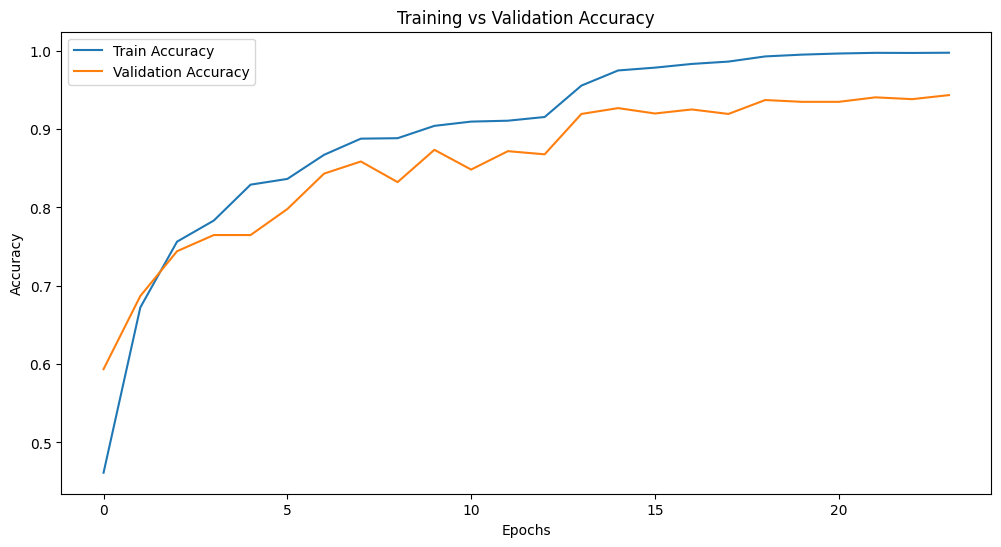

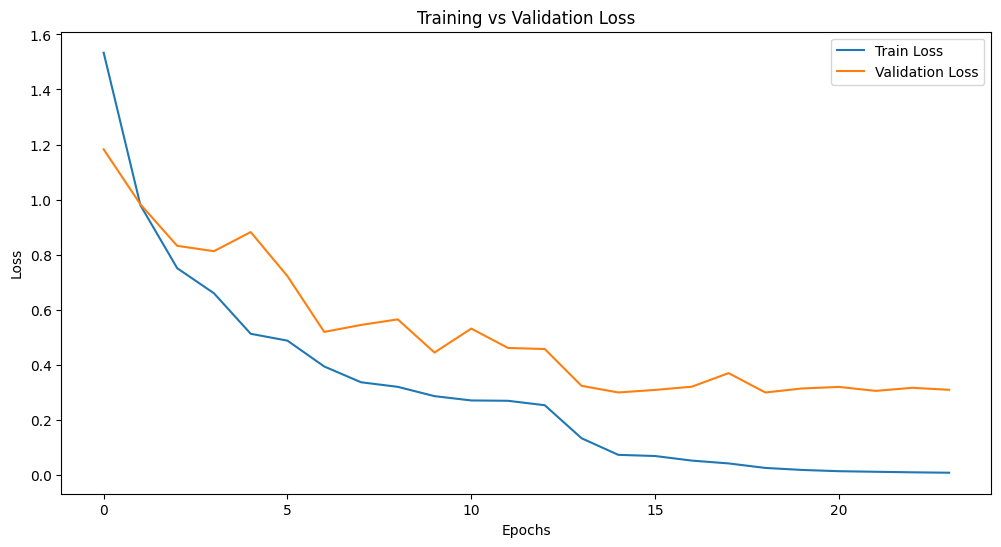

In [35]:
# ✅ Courbes de performance
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


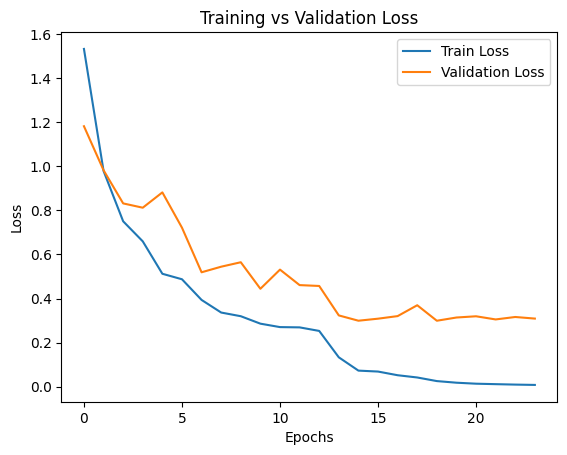

In [36]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


## Étape 8 : Évaluer et Sauvegarder le Modèle

### 8.1. Évaluer le Modèle

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


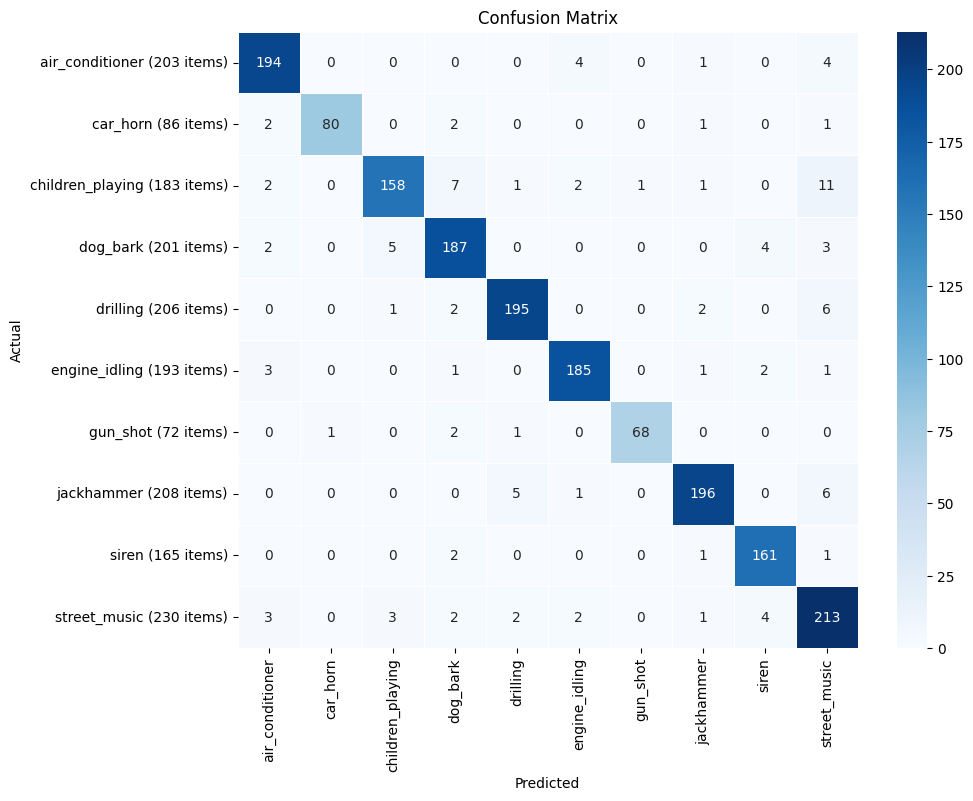


Classification Report:
                   precision    recall  f1-score   support

 air_conditioner       0.94      0.96      0.95       203
        car_horn       0.99      0.93      0.96        86
children_playing       0.95      0.86      0.90       183
        dog_bark       0.91      0.93      0.92       201
        drilling       0.96      0.95      0.95       206
   engine_idling       0.95      0.96      0.96       193
        gun_shot       0.99      0.94      0.96        72
      jackhammer       0.96      0.94      0.95       208
           siren       0.94      0.98      0.96       165
    street_music       0.87      0.93      0.89       230

        accuracy                           0.94      1747
       macro avg       0.95      0.94      0.94      1747
    weighted avg       0.94      0.94      0.94      1747



In [22]:
# ✅ Evaluate Model Performance
val_preds = np.argmax(model.predict(val_spectrograms), axis=1)

# ✅ Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, 
            xticklabels=CLASSES, yticklabels=[f"{CLASSES[i]} ({cm[i].sum()} items)" for i in range(len(CLASSES))], cbar=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ Classification Report
print("\nClassification Report:\n", classification_report(val_labels, val_preds, target_names=CLASSES))

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


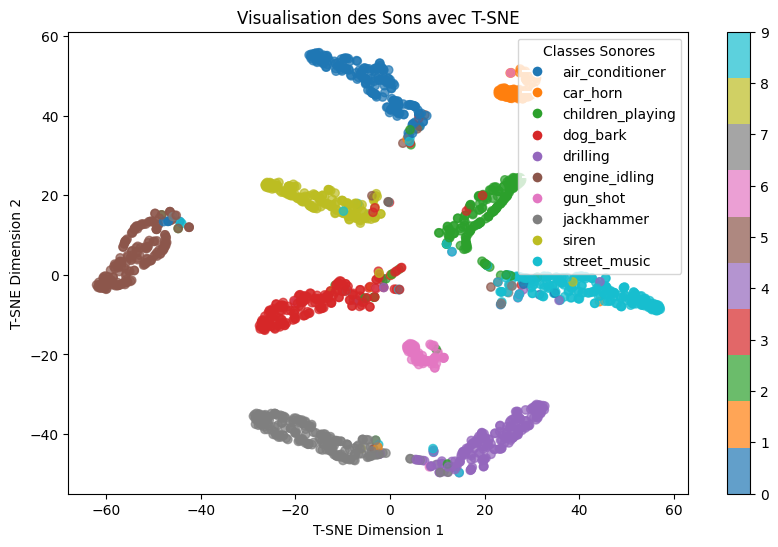

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
 
# ✅ Réduction de dimension avec T-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(model.predict(val_spectrograms))
 
# ✅ Affichage des points en 2D
plt.figure(figsize=(10, 6))
 
# ✅ Tracer chaque classe avec un label distinct
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=val_labels, cmap="tab10", alpha=0.7)
 
# ✅ Ajouter une légende avec les noms des classes
legend_labels = {i: CLASSES[i] for i in range(NUM_CLASSES)}  # Associer couleurs & classes
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=scatter.cmap(scatter.norm(i))) 
           for i in range(NUM_CLASSES)]
 
plt.legend(handles, legend_labels.values(), title="Classes Sonores", loc="upper right", fontsize=10)
 
plt.colorbar(scatter, ticks=range(NUM_CLASSES))
plt.xlabel("T-SNE Dimension 1")
plt.ylabel("T-SNE Dimension 2")
plt.title("Visualisation des Sons avec T-SNE")
plt.show()

### 8.2. Sauvegarder le Modèle

In [32]:
# ✅ Save the trained model
model.save("/kaggle/working/timescalenet_urbansound8k.h5")
print("✅ Model saved successfully!")

✅ Model saved successfully!


In [27]:
import os

# Lister les fichiers dans /kaggle/working/
print(os.listdir("/kaggle/working/"))

['.virtual_documents', 'timescalenet_urbansound8k.h5']


## Étape 9 : Tester le modèle 
### 9.1 : Charger et Prétraiter les Audios

Voici comment charger et prétraiter les fichiers audio pour les passer au modèle :

**Fonction pour Charger et Prétraiter un Fichier Audio :**

In [29]:
def process_audio_file(file_path):
    # Load the audio file
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE)
    
    # Convert to Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=1024, hop_length=512
    )
    log_mel_spec = np.log(mel_spec + 1e-9).T
    
    # Pad or truncate the spectrogram
    log_mel_spec = pad_or_truncate(log_mel_spec)
    
    # Normalize the spectrogram
    log_mel_spec = (log_mel_spec - mean) / std
    
    # Reshape for model input
    log_mel_spec = np.expand_dims(log_mel_spec, axis=0)
    
    return log_mel_spec

**Fonction pour Prédire la Classe d'un Fichier Audio :**

In [30]:
def predict_audio_class(file_path):
    # Process the audio file
    log_mel_spec = process_audio_file(file_path)
    
    # Predict the class
    prediction = model.predict(log_mel_spec)
    predicted_class = np.argmax(prediction, axis=1)[0]
    
    # Display the predicted class and confidence
    confidence = np.max(prediction)
    print(f"File: {os.path.basename(file_path)}")
    print(f"Predicted Class: {CLASSES[predicted_class]} (Confidence: {confidence:.2f})")
    print("-" * 50)

## 9.2 : Tester les Audios Téléchargés

**Charger les Fichiers Audio**

Supposons que vous avez placé les fichiers audio dans le dossier /kaggle/input/freesound-audios/. Voici comment les tester :

In [31]:
# Path to the folder containing Freesound audios
freesound_folder = "/kaggle/input/sirens/"

# List all audio files in the folder
audio_files = [os.path.join(freesound_folder, f) for f in os.listdir(freesound_folder) if f.endswith(".wav") or f.endswith(".mp3")]

# Test each audio file
for audio_file in audio_files:
    predict_audio_class(audio_file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
File: siren8.wav
Predicted Class: street_music (Confidence: 0.44)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
File: siren3.wav
Predicted Class: siren (Confidence: 1.00)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
File: siren1.wav
Predicted Class: siren (Confidence: 0.99)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
File: siren7.wav
Predicted Class: dog_bark (Confidence: 0.90)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
File: siren2.wav
Predicted Class: siren (Confidence: 1.00)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
File: siren6.wav
Predicted Class: dog_bark (Confidence: 0.91)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
File: siren9.wav
Predicted Class: siren (Confidence: 1.00)
--